In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
import scipy.optimize as optimize
import numpy as np
import statsmodels.api as sm
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.optimize import minimize

from IPython.display import display, HTML
display(HTML("<style>.jp-Cell { margin-left: -35% !important; margin-right: -35% !important; }</style>"))

In [2]:
def extract_tasklog_features(tasklog_path: str):
    """
    주어진 .tasklog 파일을 읽어서 Required Accelerator Count를 그룹화한 후,
    Accumulated Age의 평균 및 최대값을 특성 벡터로 반환.

    :param tasklog_path: .tasklog 파일 경로
    :return: 특성 벡터를 포함한 딕셔너리
    """
    # .tasklog 파일 읽기
    try:
        tasklog_data = pd.read_csv(tasklog_path)
    except Exception as e:
        print(f"Error reading {tasklog_path}: {e}")
        return {}

    # Required Accelerator Count 그룹의 평균 및 최대 Accumulated Age 계산
    grouped_data_mean = tasklog_data.groupby('Required Accelerator Count')['Accumulated Age'].mean()
    grouped_data_max = tasklog_data.groupby('Required Accelerator Count')['Accumulated Age'].max()

    # 특성 벡터 생성
    feature_vector = {}
    
    # 평균값과 최대값을 벡터에 추가
    for count, age_mean in grouped_data_mean.items():
        feature_vector[f'Avg_Age_Accel_{count}'] = age_mean
    
    for count, age_max in grouped_data_max.items():
        feature_vector[f'Max_Age_Accel_{count}'] = age_max

    return feature_vector

In [3]:
def extract_reference_rows(df: pd.DataFrame):
    """
    주어진 DataFrame에서 'preemption enabling'이 FALSE이고 'starvation prevention'이 FALSE인 행을 추출하여
    별도의 CSV 파일로 저장.

    :param df: 기준 데이터를 추출할 pandas DataFrame
    :param output_path: 추출된 데이터를 저장할 CSV 파일 경로 (기본값: 'reference_rows.csv')
    :return: 추출된 기준 행들을 포함한 pandas DataFrame
    """
    # 기준 열을 추출 (preemption enabling이 FALSE이고 starvation prevention이 FALSE인 행)
    reference_df = df[(df['preemption enabling'] == False) & (df['starvation prevention'] == False)]
   
    return reference_df

In [4]:
def add_time_gain_column_with_ref(df: pd.DataFrame, ref: pd.Series):
    """
    기준(ref)의 Total Emulation minutes을 사용하여, 각 row의 Total Emulation minutes과 Ajust task taken time(min)의 차이를 
    time gain이라는 컬럼으로 추가.

    :param df: pandas DataFrame
    :param ref: 기준이 되는 row (pandas Series)
    :return: time gain 컬럼이 추가된 DataFrame
    """
    # ref의 Total Emulation minutes 값을 가져옴
    ref_total_emulation_minutes = ref['Total Emulation minutes']

    # 기준(ref)의 Total Emulation minutes에서 각 row의 Total Emulation minutes과 Ajust task taken time(min)의 합을 빼서 새로운 컬럼 추가
    df['Peemption gain'] = df.apply(lambda row: ref_total_emulation_minutes - row['Total Emulation minutes'] - row['Ajust task taken time(min)'] 
                               if row['preemption enabling'] == True else 0, axis=1)
    
    
    return df

In [5]:
def calculate_dist_for_all_rows(df: pd.DataFrame, ref: pd.Series):
    """
    df의 모든 row와 ref의 값을 비교하여 Accumulated avg dist와 Accumulated max dist를 계산.
    람다식을 사용하여 계산하고, 각 row에 결과를 추가함.
    """

    # 가중치 설정
    weights = [1 / (2 ** (8 - i)) for i in range(1, 9)]  # [1, 1/2, 1/4, ..., 1/128]

    # Accumulated avg dist 계산
    df['Accumulated avg dist'] = df.apply(lambda row: sum(
        (row[f'Avg_Age_Accel_{i}'] - ref[f'Avg_Age_Accel_{i}']) * weights[i - 1]
        if f'Avg_Age_Accel_{i}' in df.columns and f'Avg_Age_Accel_{i}' in ref else 0 for i in range(1, 9)), axis=1)

    # Accumulated max dist 계산
    df['Accumulated max dist'] = df.apply(lambda row: sum(
        (row[f'Max_Age_Accel_{i}'] - ref[f'Max_Age_Accel_{i}']) * weights[i - 1]
        if f'Max_Age_Accel_{i}' in df.columns and f'Max_Age_Accel_{i}' in ref else 0 for i in range(1, 9)), axis=1)

    return df


In [11]:
def merge_meta_files_to_csv(folder_path: str, overwrite: bool = False, output_csv: str = 'merged_meta_data.csv'):
    """
    주어진 폴더에서 .meta 파일을 읽어 첫 줄을 무시하고, 각 파일의 key-value 데이터를 하나의 CSV 파일로 병합하고,
    동일한 이름의 .tasklog 파일에서 Required Accelerator Count 특성 벡터를 추출하여 추가.

    :param folder_path: .meta 파일들이 위치한 폴더 경로
    :param output_csv: 결과로 저장할 CSV 파일 이름 (기본값: 'merged_meta_data.csv')
    :return: 병합된 데이터가 포함된 pandas DataFrame
    """

    output_csv_path = os.path.join(folder_path, output_csv)

    # 기존에 merged_meta_data.csv 파일이 있는 경우, 해당 파일을 읽어서 반환
    if os.path.exists(output_csv_path):
        if not overwrite:
            print(f"Found existing file: {output_csv_path}. Reading the file.")
            return pd.read_csv(output_csv_path)
        else:
            print(f"Found existing file: {output_csv_path}. Overwriting as requested.")

        
    # .meta 파일을 읽어서 각 파일의 데이터를 저장할 리스트
    data_list = []

    # 폴더 내 모든 .meta 파일을 찾음
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.meta'):
            # 파일 경로 설정
            file_path = os.path.join(folder_path, file_name)
            
            # 각 .meta 파일을 읽어서 데이터를 key-value 형식으로 저장
            data = {}
            with open(file_path, 'r', encoding='utf-8') as file:
                # 첫 줄을 건너뛰고 두 번째 줄부터 읽음
                next(file)  # 첫 줄 무시
                for line in file:
                    if ',' in line:
                        key, value = line.strip().split(',', 1)
                        data[key] = value
            
            # .meta 파일과 동일한 이름의 .tasklog 파일 경로 설정
            tasklog_file_path = file_path.replace('.meta', '.tasklog')
            if os.path.exists(tasklog_file_path):
               # print(f"Found corresponding tasklog file: {tasklog_file_path}")
                # tasklog 파일에서 특성 벡터를 추출
                tasklog_features = extract_tasklog_features(tasklog_file_path)
                if tasklog_features:
                   
                    # 특성 벡터를 .meta 데이터에 병합
                    data.update(tasklog_features)
                
            # data_list에 추가
            data_list.append(data)

    # 모든 파일의 데이터를 DataFrame으로 변환
    df = pd.DataFrame(data_list)

    # 중복된 데이터를 제거 (job file, save prefix 제외)
    cols_to_compare = df.columns.difference(['start time', 'Expriment taken(msec)', 'Expriment taken', 'job file', 'save prefix'])
    df_unique = df.drop_duplicates(subset=cols_to_compare)

    # 입력된 폴더 경로에 CSV 파일 저장
    df_unique.to_csv(output_csv_path, index=False)
    df = pd.read_csv(output_csv_path)

    print(f"Data merged and saved to {output_csv_path}")

    ref = extract_reference_rows(df)
    df_with_gain = add_time_gain_column_with_ref(df, ref)
    df_with_gain_n_accumulate_dis = calculate_dist_for_all_rows(df_with_gain, ref)
    df_with_gain_n_accumulate_dis.to_csv(output_csv_path, index=False)
    
    return pd.read_csv(output_csv_path)

In [13]:
df = merge_meta_files_to_csv('20240929_003_first_all_try')
#df = merge_meta_files_to_csv('20240929_003_first_all_try', True)

df

Found existing file: 20240929_003_first_all_try/merged_meta_data.csv. Reading the file.


,start time,scheduler index,scheduler name,Total Job,Total Duration(Expected),Total Emulation minutes,Total Emulation Time,Expriment taken(msec),Expriment taken,preemption enabling,...,Max_Age_Accel_1,Max_Age_Accel_2,Max_Age_Accel_3,Max_Age_Accel_4,Max_Age_Accel_5,Max_Age_Accel_6,Max_Age_Accel_8,Peemption gain,Accumulated avg dist,Accumulated max dist
0,2024-09-29 10:38:45+00:00,0,mostallocated,808,131205,415841,288 Day(s) 18:41,2365,00:00:02:365,True,...,76072,76212,76361,70431,80595,65386,117664,76680,26447.522319,33370.484375
1,2024-09-29 10:38:45+00:00,0,mostallocated,808,131205,417166,289 Day(s) 16:46,2229,00:00:02:229,True,...,56597,38573,22493,80507,7095,62557,117633,75365,16147.695373,21650.851562
2,2024-09-29 10:38:45+00:00,0,mostallocated,808,131205,492556,342 Day(s) 01:16,2427,00:00:02:427,False,...,102874,99686,99810,54900,28453,15782,102874,0,0.000000,0.000000
3,2024-09-29 10:38:45+00:00,0,mostallocated,808,131205,416822,289 Day(s) 11:02,2555,00:00:02:555,True,...,75510,61603,30237,71862,7724,57210,117656,75719,12748.576717,20625.015625
4,2024-09-29 10:38:47+00:00,0,mostallocated,808,131205,417166,289 Day(s) 16:46,2111,00:00:02:111,True,...,56597,38573,22493,80507,7095,62557,117633,75370,16115.323945,21650.851562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20319,2024-09-29 15:14:25+00:00,0,mostallocated,808,131205,433986,301 Day(s) 09:06,1402,00:00:01:402,True,...,54859,56733,52097,50860,38916,64133,66259,58540,16930.046429,-26009.164062
20320,2024-09-29 15:14:26+00:00,0,mostallocated,808,131205,433383,300 Day(s) 23:03,1393,00:00:01:393,True,...,54859,56733,52097,50860,73312,71141,66259,59153,19525.720938,-19957.664062
20321,2024-09-29 15:14:27+00:00,0,mostallocated,808,131205,433986,301 Day(s) 09:06,1482,00:00:01:482,True,...,54859,56733,52097,50860,42638,64133,66259,58535,17242.268217,-25543.914062
20322,2024-09-29 15:14:29+00:00,0,mostallocated,808,131205,433986,301 Day(s) 09:06,1468,00:00:01:468,True,...,54859,56733,52097,50860,42638,64133,66259,58535,17242.268217,-25543.914062


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20324 entries, 0 to 20323
Data columns (total 54 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   start time                  20324 non-null  object 
 1   scheduler index             20324 non-null  int64  
 2   scheduler name              20324 non-null  object 
 3   Total Job                   20324 non-null  int64  
 4   Total Duration(Expected)    20324 non-null  int64  
 5   Total Emulation minutes     20324 non-null  int64  
 6   Total Emulation Time        20324 non-null  object 
 7   Expriment taken(msec)       20324 non-null  int64  
 8   Expriment taken             20324 non-null  object 
 9   preemption enabling         20324 non-null  bool   
 10  scheduling with flavor      20324 non-null  bool   
 11  perform until finish        20324 non-null  bool   
 12  starvation prevention       20324 non-null  bool   
 13  alpha                       203

/tmp/ipykernel_221112/650832327.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_range['alpha'] = pd.to_numeric(df_range['alpha'], errors='coerce')
/tmp/ipykernel_221112/650832327.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_range['beta'] = pd.to_numeric(df_range['beta'], errors='coerce')
/tmp/ipykernel_221112/650832327.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

alpha: 0.0 ~ 1.99
beta: 80 ~ 95
w: 20 ~ 100
d: 100000 ~ 500000


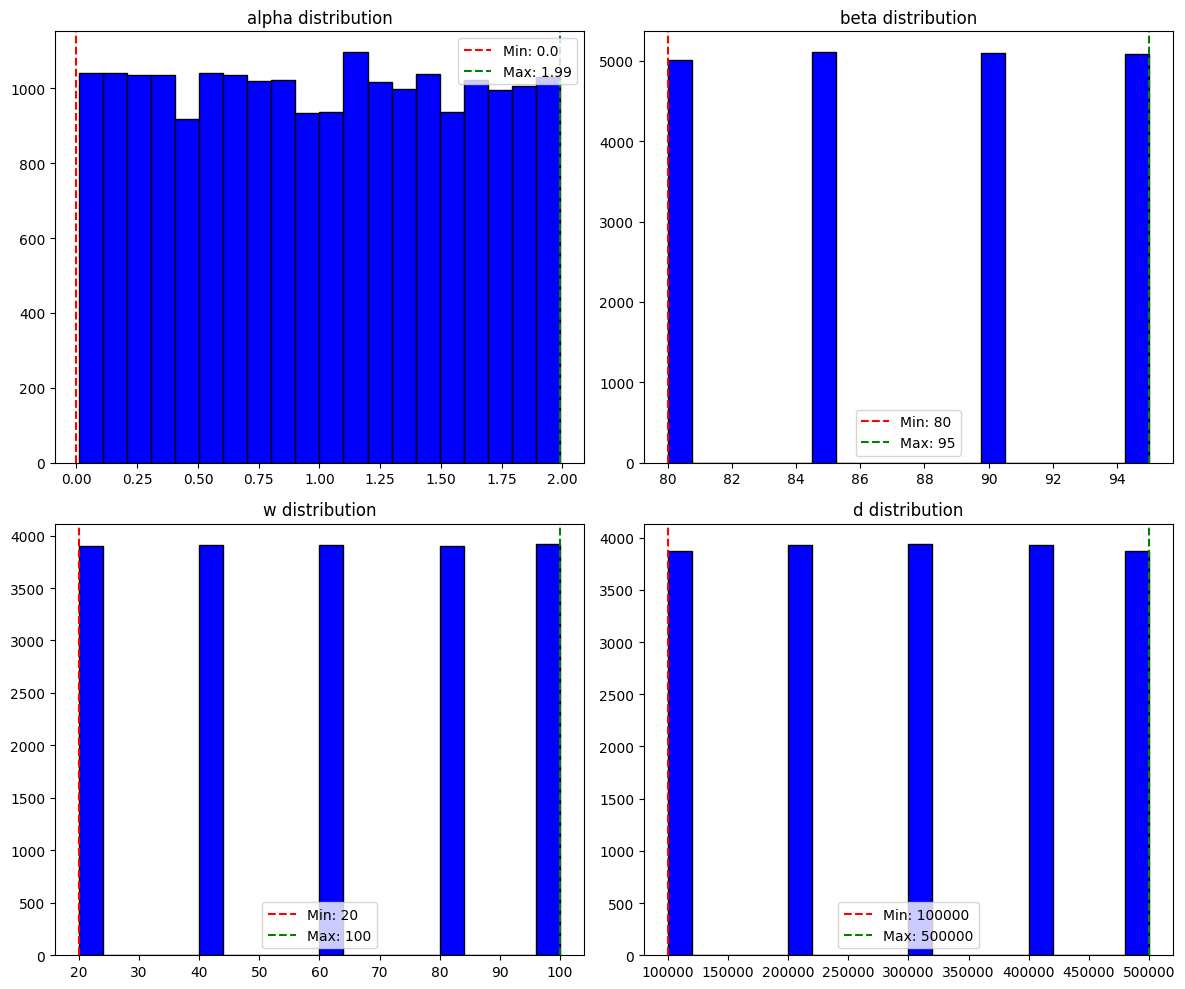

In [15]:
# alpha, beta, w, d 컬럼 선택
df_range = df[['alpha', 'beta', 'w', 'd']]

# 각 컬럼을 숫자형으로 변환 (변환 불가능한 값은 NaN으로 처리)
df_range['alpha'] = pd.to_numeric(df_range['alpha'], errors='coerce')
df_range['beta'] = pd.to_numeric(df_range['beta'], errors='coerce')
df_range['w'] = pd.to_numeric(df_range['w'], errors='coerce')
df_range['d'] = pd.to_numeric(df_range['d'], errors='coerce')

# NaN 값 제거
df_range = df_range.dropna()

# 0을 제외한 각 컬럼의 최소값, 최대값 계산
alpha_min, alpha_max = df_range['alpha'].min(), df_range[df_range['alpha'] > 0]['alpha'].max()
beta_min, beta_max = df_range[df_range['beta'] > 0]['beta'].min(), df_range[df_range['beta'] > 0]['beta'].max()
w_min, w_max = df_range[df_range['w'] > 0]['w'].min(), df_range[df_range['w'] > 0]['w'].max()
d_min, d_max = df_range[df_range['d'] > 0]['d'].min(), df_range[df_range['d'] > 0]['d'].max()

# 결과 출력
print(f"alpha: {alpha_min} ~ {alpha_max}")
print(f"beta: {beta_min} ~ {beta_max}")
print(f"w: {w_min} ~ {w_max}")
print(f"d: {d_min} ~ {d_max}")

plt.figure(figsize=(12, 10))

# alpha
plt.subplot(2, 2, 1)
plt.hist(df_range[df_range['alpha'] > 0]['alpha'], bins=20, color='blue', edgecolor='black')
plt.axvline(alpha_min, color='red', linestyle='--', label=f'Min: {alpha_min}')
plt.axvline(alpha_max, color='green', linestyle='--', label=f'Max: {alpha_max}')
plt.title('alpha distribution')
plt.legend()

# beta
plt.subplot(2, 2, 2)
plt.hist(df_range[df_range['beta'] > 0]['beta'], bins=20, color='blue', edgecolor='black')
plt.axvline(beta_min, color='red', linestyle='--', label=f'Min: {beta_min}')
plt.axvline(beta_max, color='green', linestyle='--', label=f'Max: {beta_max}')
plt.title('beta distribution')
plt.legend()

# w
plt.subplot(2, 2, 3)
plt.hist(df_range[df_range['w'] > 0]['w'], bins=20, color='blue', edgecolor='black')
plt.axvline(w_min, color='red', linestyle='--', label=f'Min: {w_min}')
plt.axvline(w_max, color='green', linestyle='--', label=f'Max: {w_max}')
plt.title('w distribution')
plt.legend()

# d
plt.subplot(2, 2, 4)
plt.hist(df_range[df_range['d'] > 0]['d'], bins=20, color='blue', edgecolor='black')
plt.axvline(d_min, color='red', linestyle='--', label=f'Min: {d_min}')
plt.axvline(d_max, color='green', linestyle='--', label=f'Max: {d_max}')
plt.title('d distribution')
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
# Total Emulation minutes, alpha, beta, w, d 컬럼 선택 및 전처리
df_selected = df[['Total Emulation minutes', 'alpha', 'beta', 'w', 'd']].dropna()

df_selected['Total Emulation minutes'] = pd.to_numeric(df_selected['Total Emulation minutes'], errors='coerce')
df_selected['alpha'] = pd.to_numeric(df_selected['alpha'], errors='coerce')
df_selected['beta'] = pd.to_numeric(df_selected['beta'], errors='coerce')
df_selected['w'] = pd.to_numeric(df_selected['w'], errors='coerce')
df_selected['d'] = pd.to_numeric(df_selected['d'], errors='coerce')

# 변환 후 NaN 값이 있을 경우 제거
df_selected = df_selected.dropna()

# 종속 변수와 독립 변수 정의
X = df_selected[['alpha', 'beta', 'w', 'd']]  # 독립 변수
y = df_selected['Total Emulation minutes']    # 종속 변수

# 상수항 추가 (절편을 포함하기 위해)
X = sm.add_constant(X)

# 회귀 분석 모델 생성 및 학습
model = sm.OLS(y, X).fit()

# 분석 결과 출력
print(model.summary())

                               OLS Regression Results                              
Dep. Variable:     Total Emulation minutes   R-squared:                       0.681
Model:                                 OLS   Adj. R-squared:                  0.681
Method:                      Least Squares   F-statistic:                 1.083e+04
Date:                     Mon, 30 Sep 2024   Prob (F-statistic):               0.00
Time:                             23:43:50   Log-Likelihood:            -2.0776e+05
No. Observations:                    20324   AIC:                         4.155e+05
Df Residuals:                        20319   BIC:                         4.156e+05
Df Model:                                4                                         
Covariance Type:                 nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
co

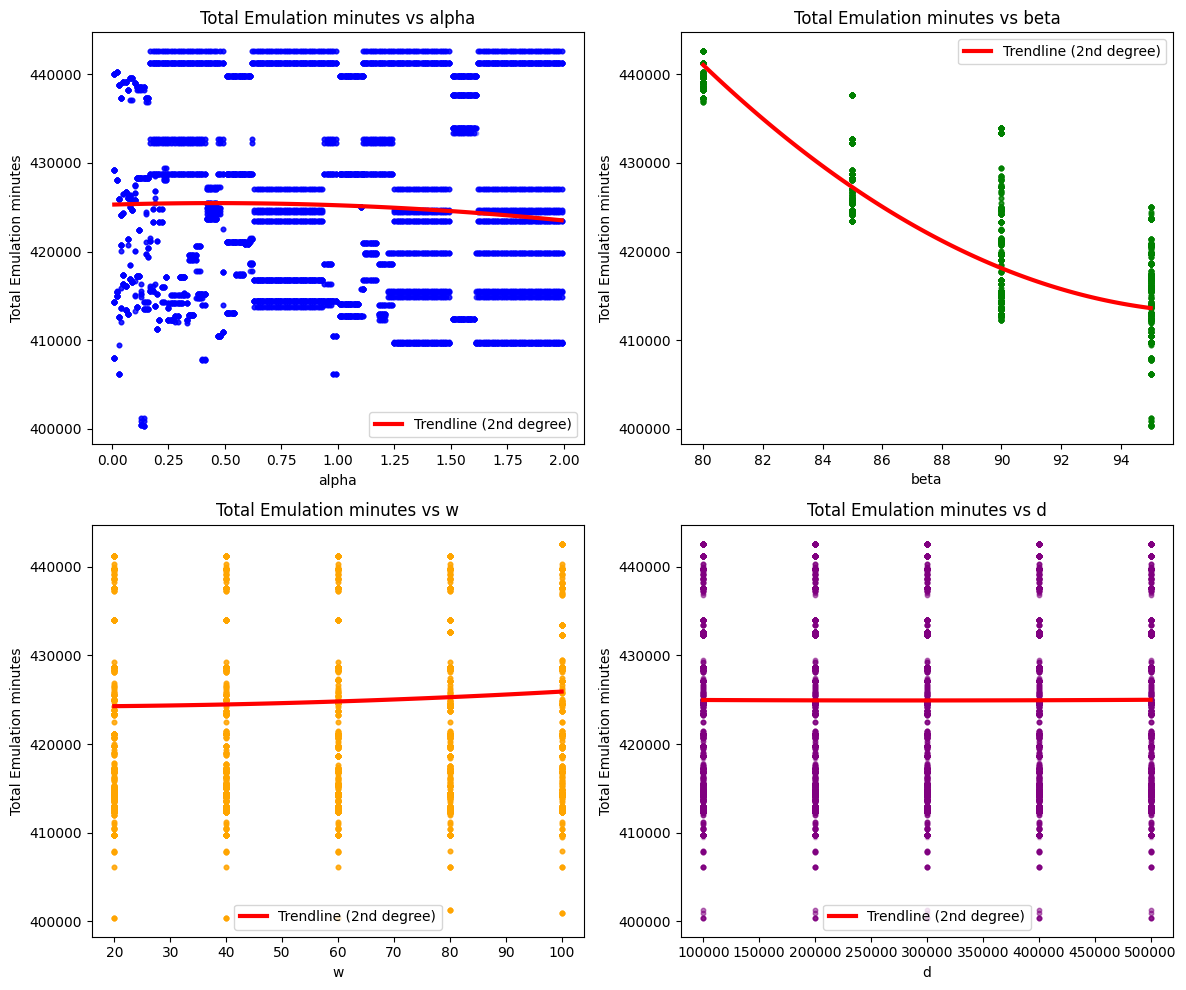

In [17]:
variables_to_plot = ['alpha', 'beta', 'w', 'd']
filtered_data = df[(df['alpha'] != 0) & (df['beta'] != 0) & (df['w'] != 0) & (df['d'] != 0)]

# 색상 설정
colors = ['blue', 'green', 'orange', 'purple']

# 산점도와 2차 회귀 추세선 그리기
plt.figure(figsize=(12, 10))

for i, (var, color) in enumerate(zip(variables_to_plot, colors), 1):
    plt.subplot(2, 2, i)
    
    # 산점도 그리기 (각 변수에 맞는 색상)
    plt.scatter(filtered_data[var], filtered_data['Total Emulation minutes'], alpha=0.3, color=color, s=10)
    
    # 2차 회귀 추세선 그리기 (붉은색으로)
    poly_fit = np.poly1d(np.polyfit(filtered_data[var], filtered_data['Total Emulation minutes'], 2))
    poly_line = np.linspace(filtered_data[var].min(), filtered_data[var].max(), 100)
    
    plt.plot(poly_line, poly_fit(poly_line), color='red', linewidth=3, label='Trendline (2nd degree)')
    
    plt.title(f'Total Emulation minutes vs {var}')
    plt.xlabel(var)
    plt.ylabel('Total Emulation minutes')
    plt.legend()

# 그래프 출력
plt.tight_layout()
plt.show()

In [20]:
!python3 -m pip install --upgrade pip

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 7.2 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 24.0
    Uninstalling pip-24.0:
      Successfully uninstalled pip-24.0


In [22]:
!pip install bayesian-optimization

Defaulting to user installation because normal site-packages is not writeable


In [28]:
# Define the function to minimize using Bayesian Optimization
def objective_function_bayes(alpha, beta):
    # Filter the data based on the current alpha and beta
    filtered_data = df[
        (df['alpha'] == alpha) & 
        (df['beta'] == beta)
    ]
    
    # If no matching data, return a large value
    if len(filtered_data) == 0:
        return -np.inf
    
    # Calculate Total Emulation minutes, Accumulated avg dist, and Accumulated max dist
    total_emulation_min = np.abs(filtered_data['Total Emulation minutes'].mean())
    accumulated_avg_dist = np.abs(filtered_data['Accumulated avg dist'].mean())
    accumulated_max_dist = np.abs(filtered_data['Accumulated max dist'].mean())
    
    # Objective: Minimize the sum of these three metrics (since the goal is to minimize these values)
    return -(total_emulation_min + accumulated_avg_dist + accumulated_max_dist)

# Define the bounds for alpha and beta
pbounds = {
    'alpha': (df['alpha'].min(), df['alpha'].max()),
    'beta': (df['beta'].min(), df['beta'].max())
}

# Set up the Bayesian Optimization
optimizer = BayesianOptimization(
    f=objective_function_bayes,
    pbounds=pbounds,
    random_state=42
)

# Maximize the negative objective function (since we are minimizing the original function)
optimizer.maximize(
    init_points=10,  # Initial random explorations
    n_iter=50  # Number of iterations for optimization
)

# Extracting the best result
best_params = optimizer.max['params']
print("Best parameters found: alpha = {}, beta = {}".format(best_params['alpha'], best_params['beta']))


|   iter    |  target   |   alpha   |   beta    |
-------------------------------------------------
| 1         | -inf      | 0.7453    | 90.32     |
| 2         | -inf      | 1.457     | 56.87     |
| 3         | -inf      | 0.3105    | 14.82     |
| 4         | -inf      | 0.1156    | 82.29     |
| 5         | -inf      | 1.196     | 67.27     |
| 6         | -inf      | 0.04096   | 92.14     |
| 7         | -inf      | 1.657     | 20.17     |
| 8         | -inf      | 0.3618    | 17.42     |
| 9         | -inf      | 0.6054    | 49.85     |
| 10        | -inf      | 0.8596    | 27.67     |


ValueError: Input y contains infinity or a value too large for dtype('float64').

In [37]:
# Total Emulation minutes를 최소화하기 위한 함수 정의 (다차원 회귀 기반)
def objective_function(params):
    alpha, beta, w, d = params
    # 2차 다차원 회귀 모델을 이용해 Total Emulation minutes를 예측
    poly_fit = np.poly1d(np.polyfit(filtered_data['alpha'], filtered_data['Total Emulation minutes'], 2))
    return poly_fit(alpha)  # 주어진 alpha, beta, w, d에 대해 예측값 반환


In [38]:

# 초기 값 설정 (임의의 값으로 시작)
initial_guess = [filtered_data['alpha'].mean(), filtered_data['beta'].mean(), filtered_data['w'].mean(), filtered_data['d'].mean()]

# 변수들의 범위 설정 (현실적인 값으로 제한)
bounds = [(filtered_data['alpha'].min(), filtered_data['alpha'].max()),
          (filtered_data['beta'].min(), filtered_data['beta'].max()),
          (filtered_data['w'].min(), filtered_data['w'].max()),
          (filtered_data['d'].min(), filtered_data['d'].max())]

# 최소화 최적화 실행 (SLSQP 알고리즘 사용)
result = minimize(objective_function, initial_guess, bounds=bounds, method='SLSQP')

# 최적화 결과 출력
optimal_values = result.x
optimal_values

# 최적화 결과를 보기 좋은 형식으로 출력하도록 수정
optimal_values_dict = {
    'alpha': optimal_values[0],
    'beta': optimal_values[1],
    'w': optimal_values[2],
    'd': optimal_values[3]
}

# 보기 좋은 형식으로 출력
for param, value in optimal_values_dict.items():
    print(f"{param}: {value:.2f}")


alpha: 1.99
beta: 87.53
w: 60.02
d: 299927.87


# Total Emulation minutes, alpha, beta, w, d 컬럼 선택
df_selected = df[['Total Emulation minutes', 'alpha', 'beta', 'w', 'd']].dropna()

# 데이터 타입 확인 및 변환 (문자열이 있을 경우 숫자로 변환)
df_selected['Total Emulation minutes'] = pd.to_numeric(df_selected['Total Emulation minutes'], errors='coerce')
df_selected['alpha'] = pd.to_numeric(df_selected['alpha'], errors='coerce')
df_selected['beta'] = pd.to_numeric(df_selected['beta'], errors='coerce')
df_selected['w'] = pd.to_numeric(df_selected['w'], errors='coerce')
df_selected['d'] = pd.to_numeric(df_selected['d'], errors='coerce')

# 변환 후 NaN 값이 있을 경우 제거
df_selected = df_selected.dropna()

# 그래프 그리기
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Total Emulation minutes vs alpha, beta, w, d (excluding zero values in analysis)')

# alpha vs Total Emulation minutes (alpha가 0이 아닌 경우만)
sns.regplot(x='alpha', y='Total Emulation minutes', data=df_selected[df_selected['alpha'] != 0], ax=axes[0, 0])
axes[0, 0].set_title('alpha vs Total Emulation minutes')

# beta vs Total Emulation minutes (beta가 0이 아닌 경우만)
sns.regplot(x='beta', y='Total Emulation minutes', data=df_selected[df_selected['beta'] != 0], ax=axes[0, 1])
axes[0, 1].set_title('beta vs Total Emulation minutes')

# w vs Total Emulation minutes (w가 0이 아닌 경우만)
sns.regplot(x='w', y='Total Emulation minutes', data=df_selected[df_selected['w'] != 0], ax=axes[1, 0])
axes[1, 0].set_title('w vs Total Emulation minutes')

# d vs Total Emulation minutes (d가 0이 아닌 경우만)
sns.regplot(x='d', y='Total Emulation minutes', data=df_selected[df_selected['d'] != 0], ax=axes[1, 1])
axes[1, 1].set_title('d vs Total Emulation minutes')

# 그래프 간격 조정
plt.tight_layout(rect=[0, 0, 1, 0.96])

# 그래프 출력
plt.show()

# Total Emulation minutes, alpha, beta, w, d 컬럼 선택
df_selected = df[['Total Emulation minutes', 'alpha', 'beta', 'w', 'd']].dropna()

# 데이터 타입 확인 및 변환 (문자열이 있을 경우 숫자로 변환)
df_selected['Total Emulation minutes'] = pd.to_numeric(df_selected['Total Emulation minutes'], errors='coerce')
df_selected['alpha'] = pd.to_numeric(df_selected['alpha'], errors='coerce')
df_selected['beta'] = pd.to_numeric(df_selected['beta'], errors='coerce')
df_selected['w'] = pd.to_numeric(df_selected['w'], errors='coerce')
df_selected['d'] = pd.to_numeric(df_selected['d'], errors='coerce')

# 변환 후 NaN 값이 있을 경우 제거
df_selected = df_selected.dropna()

# 종속 변수와 독립 변수 정의
X = df_selected[['alpha', 'beta', 'w', 'd']]  # 독립 변수
y = df_selected['Total Emulation minutes']    # 종속 변수

# 상수항 추가 (절편을 포함하기 위해)
X = sm.add_constant(X)

# 회귀 분석 모델 생성 및 학습
model = sm.OLS(y, X).fit()

# 회귀 모델을 사용해 Total Emulation minutes 예측 함수 정의
def predict_emulation_minutes(params):
    const, alpha, beta, w, d = params
    return const + model.params['alpha'] * alpha + model.params['beta'] * beta + model.params['w'] * w + model.params['d'] * d

# 최적화를 위한 목적 함수 (Total Emulation minutes 최소화)
def objective_function(params):
    return predict_emulation_minutes(params)

# 초기값 설정 (const, alpha, beta, w, d)
initial_params = [model.params['const'], model.params['alpha'], model.params['beta'], model.params['w'], model.params['d']]

# 변수에 대한 경계 설정
# const는 제한 없음, alpha는 0 이상, beta는 0 이상 100 이하, w는 0 이상, d는 100000 이상
# alpha, beta, w, d 가 0일 경우 해당 변수가 사용되지 않음을 반영함.
bounds = [(None, None), (0, None), (0, 100), (0, None), (100000, None)]  # (const, alpha, beta, w, d)

# 최적화 함수 (최소화할 값 찾기)
result = optimize.minimize(objective_function, initial_params, method='L-BFGS-B', bounds=bounds)

# 최적화 결과 출력
optimal_params = result.x
print(f"최적화된 값: const={optimal_params[0]}, alpha={optimal_params[1]}, beta={optimal_params[2]}, w={optimal_params[3]}, d={optimal_params[4]}")

# 최적화된 값으로 Total Emulation minutes 예측
optimal_total_emulation_minutes = predict_emulation_minutes(optimal_params)
print(f"최적화된 Total Emulation minutes: {optimal_total_emulation_minutes}")

# 결과를 그래프로 표현
params_names = ['const', 'alpha', 'beta', 'w', 'd']
plt.figure(figsize=(10, 6))
plt.bar(params_names, optimal_params)
plt.title('Optimized Values for Minimizing Total Emulation Minutes')
plt.ylabel('Parameter Values')
plt.xlabel('Parameters')
plt.show()

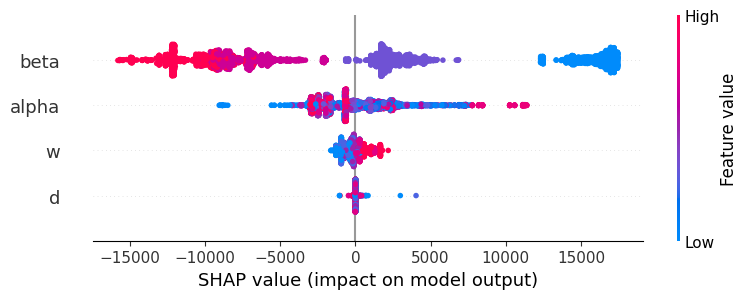

In [76]:
shap.initjs()
# Total Emulation minutes, alpha, beta, w, d 컬럼 선택
df_selected = df[['Total Emulation minutes', 'alpha', 'beta', 'w', 'd']].dropna()

# 데이터 타입 확인 및 변환 (문자열이 있을 경우 숫자로 변환)
df_selected['Total Emulation minutes'] = pd.to_numeric(df_selected['Total Emulation minutes'], errors='coerce')
df_selected['alpha'] = pd.to_numeric(df_selected['alpha'], errors='coerce')
df_selected['beta'] = pd.to_numeric(df_selected['beta'], errors='coerce')
df_selected['w'] = pd.to_numeric(df_selected['w'], errors='coerce')
df_selected['d'] = pd.to_numeric(df_selected['d'], errors='coerce')

# 변환 후 NaN 값이 있을 경우 제거
df_selected = df_selected.dropna()

# 독립 변수 중에서 alpha, beta, w, d 가 0을 초과하는 값만 선택
df_selected = df_selected[(df_selected['alpha'] > 0) & (df_selected['beta'] > 0) &
                          (df_selected['w'] > 0) & (df_selected['d'] > 0)]

# 독립 변수 (X)와 종속 변수 (y) 정의
X = df_selected[['alpha', 'beta', 'w', 'd']]
y = df_selected['Total Emulation minutes']

# 학습/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 랜덤 포레스트 회귀 모델 학습
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# SHAP 값 계산
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# SHAP 요약 플롯 출력 (변수의 중요도 분석)
shap.summary_plot(shap_values, X_test, feature_names=['alpha', 'beta', 'w', 'd'])

# SHAP 값의 force plot 출력 (특정 예측에 대해)
shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[0], feature_names=['alpha', 'beta', 'w', 'd'])

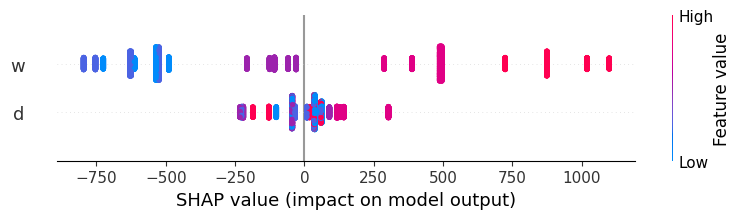

In [77]:
shap.initjs()
# Total Emulation minutes, alpha, beta, w, d 컬럼 선택
df_selected = df[['Total Emulation minutes', 'w', 'd']].dropna()

# 데이터 타입 확인 및 변환 (문자열이 있을 경우 숫자로 변환)
df_selected['Total Emulation minutes'] = pd.to_numeric(df_selected['Total Emulation minutes'], errors='coerce')
df_selected['w'] = pd.to_numeric(df_selected['w'], errors='coerce')
df_selected['d'] = pd.to_numeric(df_selected['d'], errors='coerce')

# 변환 후 NaN 값이 있을 경우 제거
df_selected = df_selected.dropna()

# 독립 변수 중에서 alpha, beta, w, d 가 0을 초과하는 값만 선택
df_selected = df_selected[(df_selected['w'] > 0) & (df_selected['d'] > 0)]

# 독립 변수 (X)와 종속 변수 (y) 정의
X = df_selected[['w', 'd']]
y = df_selected['Total Emulation minutes']

# 학습/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 랜덤 포레스트 회귀 모델 학습
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# SHAP 값 계산
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# SHAP 요약 플롯 출력 (변수의 중요도 분석)
#shap.summary_plot(shap_values, X_test, feature_names=['alpha', 'beta', 'w', 'd'])
shap.summary_plot(shap_values, X_test, feature_names=['w', 'd'])

# SHAP 값의 force plot 출력 (특정 예측에 대해)
shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[0], feature_names=['w', 'd'])

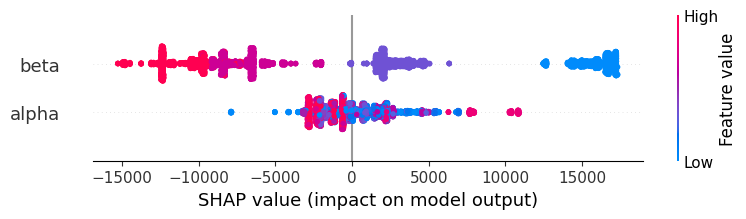

In [78]:
shap.initjs()
# Total Emulation minutes, alpha, beta, w, d 컬럼 선택
df_selected = df[['Total Emulation minutes', 'alpha', 'beta']].dropna()

# 데이터 타입 확인 및 변환 (문자열이 있을 경우 숫자로 변환)
df_selected['Total Emulation minutes'] = pd.to_numeric(df_selected['Total Emulation minutes'], errors='coerce')
df_selected['alpha'] = pd.to_numeric(df_selected['alpha'], errors='coerce')
df_selected['beta'] = pd.to_numeric(df_selected['beta'], errors='coerce')


# 변환 후 NaN 값이 있을 경우 제거
df_selected = df_selected.dropna()

# 독립 변수 중에서 alpha, beta, w, d 가 0을 초과하는 값만 선택
df_selected = df_selected[(df_selected['alpha'] > 0) & (df_selected['beta'] > 0)]

# 독립 변수 (X)와 종속 변수 (y) 정의
X = df_selected[['alpha', 'beta']]
y = df_selected['Total Emulation minutes']

# 학습/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 랜덤 포레스트 회귀 모델 학습
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# SHAP 값 계산
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# SHAP 요약 플롯 출력 (변수의 중요도 분석)
shap.summary_plot(shap_values, X_test, feature_names=['alpha', 'beta'])

# SHAP 값의 force plot 출력 (특정 예측에 대해)
shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[0], feature_names=['alpha', 'beta'])

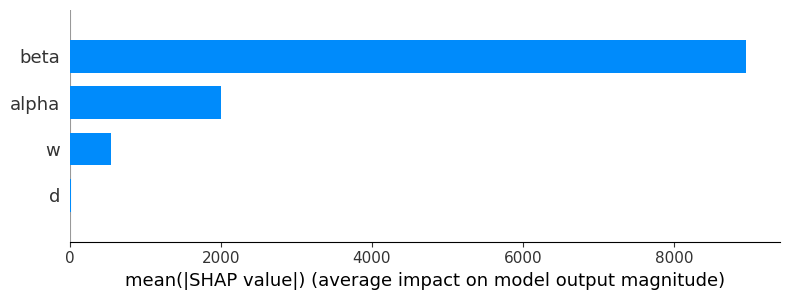

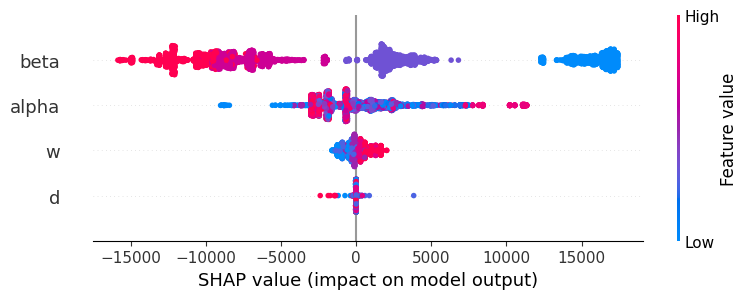

SHAP Waterfall Plot for the first sample:


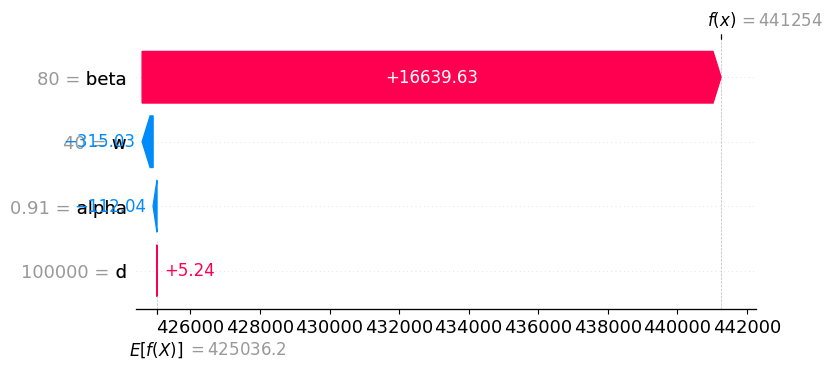

In [39]:
# SHAP 시각화를 위한 자바스크립트 초기화
shap.initjs()


# Total Emulation minutes, alpha, beta, w, d 컬럼 선택
df_selected = df[['Total Emulation minutes', 'alpha', 'beta', 'w', 'd']].dropna()

# 데이터 타입 확인 및 변환 (문자열이 있을 경우 숫자로 변환)
df_selected['Total Emulation minutes'] = pd.to_numeric(df_selected['Total Emulation minutes'], errors='coerce')
df_selected['alpha'] = pd.to_numeric(df_selected['alpha'], errors='coerce')
df_selected['beta'] = pd.to_numeric(df_selected['beta'], errors='coerce')
df_selected['w'] = pd.to_numeric(df_selected['w'], errors='coerce')
df_selected['d'] = pd.to_numeric(df_selected['d'], errors='coerce')

# 변환 후 NaN 값이 있을 경우 제거
df_selected = df_selected.dropna()

# 독립 변수 중에서 alpha, beta, w, d 가 0을 초과하는 값만 선택
df_selected = df_selected[(df_selected['alpha'] > 0) & (df_selected['beta'] > 0) &
                          (df_selected['w'] > 0) & (df_selected['d'] > 0)]

# 독립 변수 (X)와 종속 변수 (y) 정의
X = df_selected[['alpha', 'beta', 'w', 'd']]
y = df_selected['Total Emulation minutes']

# 학습/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 랜덤 포레스트 회귀 모델 학습
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# SHAP 값 계산
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test)

# SHAP 요약 플롯 출력 (bar 형태로 변경)
shap.summary_plot(shap_values, plot_type='bar')
shap.summary_plot(shap_values, X_test, feature_names=['alpha', 'beta', 'w', 'd'])

# SHAP Waterfall Plot 추가 (첫 번째 샘플에 대해)
print("SHAP Waterfall Plot for the first sample:")
shap.waterfall_plot(shap_values[0])
plt.show()

/tmp/ipykernel_26224/635770304.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['Total Emulation minutes'] = pd.to_numeric(df_selected['Total Emulation minutes'], errors='coerce')
/tmp/ipykernel_26224/635770304.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['alpha'] = pd.to_numeric(df_selected['alpha'], errors='coerce')
/tmp/ipykernel_26224/635770304.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

회귀 계수 (Coefficients): [-9.46847928e+02 -1.11444564e+03  1.37499292e+01 -1.39407339e-03]
절편 (Intercept): 523141.2348555564
MSE (Mean Squared Error): 59149434.86319754
R-squared: 0.5955922848313961


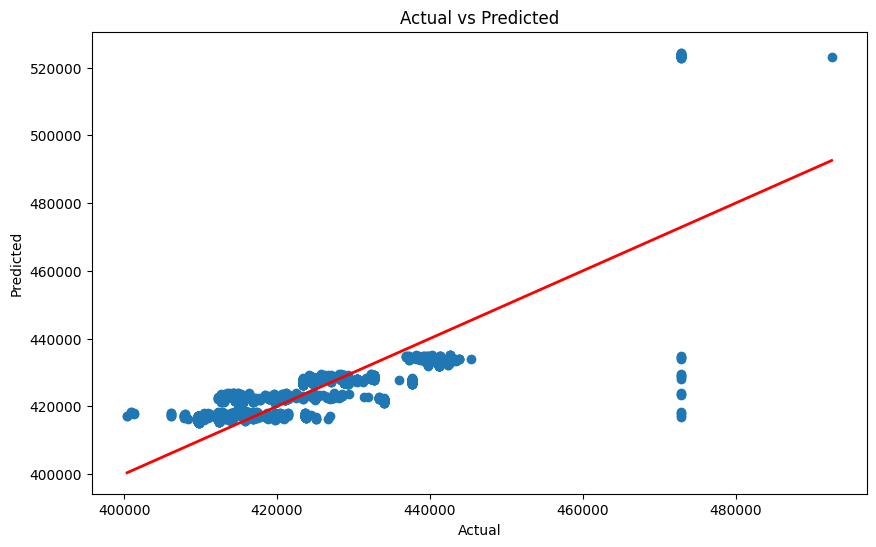

In [69]:
# Total Emulation minutes와 alpha, beta, w, d 컬럼 선택
df_selected = df[['Total Emulation minutes', 'alpha', 'beta', 'w', 'd']]

# 숫자형 데이터로 변환 (변환 불가능한 값은 NaN으로 처리)
df_selected['Total Emulation minutes'] = pd.to_numeric(df_selected['Total Emulation minutes'], errors='coerce')
df_selected['alpha'] = pd.to_numeric(df_selected['alpha'], errors='coerce')
df_selected['beta'] = pd.to_numeric(df_selected['beta'], errors='coerce')
df_selected['w'] = pd.to_numeric(df_selected['w'], errors='coerce')
df_selected['d'] = pd.to_numeric(df_selected['d'], errors='coerce')

# NaN 값 제거
df_selected = df_selected.dropna()

# 독립 변수와 종속 변수 설정
X = df_selected[['alpha', 'beta', 'w', 'd']]  # 독립 변수
y = df_selected['Total Emulation minutes']     # 종속 변수

# 학습 및 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 학습 (선형 회귀)
model = LinearRegression()
model.fit(X_train, y_train)

# 예측 값 생성
y_pred = model.predict(X_test)

# 회귀 분석 결과 출력
print("회귀 계수 (Coefficients):", model.coef_)
print("절편 (Intercept):", model.intercept_)
print("MSE (Mean Squared Error):", mean_squared_error(y_test, y_pred))
print("R-squared:", r2_score(y_test, y_pred))

# 실제 값과 예측 값 비교 시각화
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()